In [1]:
import sys
import os
import numpy as np
import pandas as pd

import h5py

import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, roc_auc_score

import anndata as ad

import pyranges as pr
import glob
import tqdm


In [5]:
#Load scooby scores for OneK1K PBMC sc-eQTLs

###########
# Code copied: from https://github.com/gagneurlab/scooby_reproducibility/blob/main/notebooks/figure4/Figure4.ipynb
###########

data_path = '/scratch5/jlinder/scooby/reproducibility_data/'

#Load GTF file
gtf_file = f"{data_path}gencode.v32.annotation.sorted.gtf.gz"
gtf = pr.read_gtf(gtf_file).df.query('Feature == "gene"')
gtf['gene_id'] = gtf['gene_id'].apply(lambda x: x.split('.')[0])
gtf = gtf[['Start','End','Strand','gene_name','gene_id']].rename(columns={'Start':'gene_start','End':'gene_end'}).drop_duplicates(subset=['gene_id','gene_name'])

#Load SuSiE fine-mapping table
susie_df = pd.read_table(f'{data_path}eQTL_fig4/all_highpip_susie.tsv')

susie_len = len(susie_df)
susie_df = susie_df.merge(gtf, on=['gene_id','gene_name'])
assert len(susie_df) == susie_len

susie_df['dist_to_tss'] = (susie_df['Pos'] - susie_df['gene_start'])*(susie_df['Strand'] == "+") + (susie_df['Pos'] - susie_df['gene_end'])*(susie_df['Strand'] == "-")
susie_df['abs_dist_to_tss'] = np.abs(susie_df['dist_to_tss'])

susie_df['unique_id'] = susie_df['variant'] + "_" + susie_df['gene_id']

#Load scooby variant effect predictions
model = 'scooby_neurips'
adata_list = []

paths = sorted(glob.glob(f'{data_path}/eQTL_fig4/scooby_variants_tsscentred/*.h5ad'),key=lambda x: int(x.split('/')[-1].split('_')[1]))
for path in tqdm.tqdm(paths):
    adata = ad.read_h5ad(path)
    adata_list.append(adata)

adata = ad.concat(adata_list, merge='same')
adata.obs_names = adata.obs['variant'] + "_" + adata.obs['gene_id']

#Append scooby scores to susie dataframe

def make_scooby_mapping(adata):
    mapping = dict()
    mapping['GTEx'] = {
        'blood' : set(susie_df.query('study_label == "OneK1K"').tissue_label.str.replace(' ', '_')),
    }
    mapping['OneK1K'] = dict()
    for ct in set(susie_df.query('study_label == "OneK1K"').tissue_label.unique()):
        mapping['OneK1K'][ct] = [ct.replace(" ", "_")]
    
    return mapping

study = 'OneK1K'

mapping = make_scooby_mapping(adata)
tissue_mapping = mapping[study]

scooby_dfs = []

#Loop over tissues
for tissue in ['NK cell', 'B cell', 'CD4+ T cell', 'monocyte', 'CD4+ TCM cell', 'CD8+ TEM cell'] :

    #Query one tissue at a time
    reduced_susie = susie_df.query('study_label == @study and tissue_label == @tissue').sort_values('sample_size',ascending=False).drop_duplicates(subset=['gene_id','variant'], keep='first')
    assert len(reduced_susie) > 0
    reduced_adata = adata[adata.obs.index.isin(set(reduced_susie['unique_id'])), adata.var.index.isin(tissue_mapping[tissue])]
    snp_effects = pd.DataFrame({'variant':reduced_adata.obs['variant'],
                                'gene_id':reduced_adata.obs['gene_id'],
                                'pred_effect':reduced_adata.X.mean(axis=1)})

    reduced_susie = reduced_susie.merge(snp_effects, on=['variant','gene_id'])
    assert len(reduced_susie) == len(snp_effects)

    scooby_df = reduced_susie.copy()
    scooby_dfs.append(scooby_df)

#Concatenate across tissues
scooby_df = pd.concat(scooby_dfs).copy()

#Verify that the Spearman R for NK cells is as expected
print(spearmanr(scooby_df.query("tissue_label == 'NK cell'")['pred_effect'], scooby_df.query("tissue_label == 'NK cell'")['beta']))


100%|█████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 101.24it/s]

SpearmanrResult(correlation=0.4306268631691073, pvalue=8.427963504577426e-12)



/home/jlinder/anaconda3/envs/borzoi_py310_sc/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [2]:
#Cache scooby prediction dataframe (unique snp/tissue-pairs)
#scooby_df_unique = scooby_df.drop_duplicates(subset=['gene_id', 'variant', 'tissue_label'], keep='first').copy()

#scooby_df_unique.to_csv('onek1k_scooby_ext.tsv', sep='\t', index=False)
scooby_df_unique = pd.read_csv('onek1k_scooby_ext.tsv', sep='\t')


In [3]:
#Calculate correlation metrics for all models

model_names = [
    'scooby',
    'prime 1x',
    'prime 4x',
]

rp_mat = np.zeros((3, 4))
rs_mat = np.zeros((3, 4))
n_mat = np.zeros(4)

tissues = ['nk_cell', 't_cell_cd4', 't_cell_cd4_tcm', 't_cell_cd8_tem']
tissues_kw = ['NK cell', 'CD4+ T cell', 'CD4+ TCM cell', 'CD8+ TEM cell']

score_cols = ['nk_cell', 't_cell_cd4', 't_cell_cd4_tcm', 't_cell_cd8_tem']

#Loop over tissues
for tissue_i, [tissue, tissue_kw, score_col] in enumerate(zip(tissues, tissues_kw, score_cols)) :
    
    #Load borzoi prime scores
    df_borz_1 = pd.read_csv('../borzoi_prime_pbmc_onek1k_' + tissue + '_pseudo_ext_pos_1_fold.tsv', sep='\t')
    df_borz_1['unique_id'] = df_borz_1['snp'] + '_' + df_borz_1['finemap_gene_id']
    df_borz_1 = df_borz_1[['unique_id', 'beta', 'score_' + score_col]].rename(columns={'score_' + score_col : 'score_borzoi_1'}).copy()
    
    df_borz_4 = pd.read_csv('../borzoi_prime_pbmc_onek1k_' + tissue + '_pseudo_ext_pos.tsv', sep='\t')
    df_borz_4['unique_id'] = df_borz_4['snp'] + '_' + df_borz_4['finemap_gene_id']
    df_borz_4 = df_borz_4[['unique_id', 'score_' + score_col]].rename(columns={'score_' + score_col : 'score_borzoi_4'}).copy()

    #Join all dataframes
    df_overlap = scooby_df_unique.query("tissue_label == '" + tissue_kw + "'")[['unique_id', 'pred_effect']].rename(columns={'pred_effect' : 'score_scooby'}).copy().reset_index(drop=True)
    df_overlap = df_overlap.join(df_borz_1.set_index('unique_id'), on='unique_id', how='inner').copy()
    df_overlap = df_overlap.join(df_borz_4.set_index('unique_id'), on='unique_id', how='inner').copy()

    #Calculate metrics
    
    n_mat[tissue_i] = len(df_overlap)
    
    rp_mat[0, tissue_i] = pearsonr(df_overlap['beta'], df_overlap['score_scooby'])[0]
    rp_mat[1, tissue_i] = pearsonr(df_overlap['beta'], df_overlap['score_borzoi_1'])[0]
    rp_mat[2, tissue_i] = pearsonr(df_overlap['beta'], df_overlap['score_borzoi_4'])[0]

    rs_mat[0, tissue_i] = spearmanr(df_overlap['beta'], df_overlap['score_scooby'])[0]
    rs_mat[1, tissue_i] = spearmanr(df_overlap['beta'], df_overlap['score_borzoi_1'])[0]
    rs_mat[2, tissue_i] = spearmanr(df_overlap['beta'], df_overlap['score_borzoi_4'])[0]

print("rp_mat.shape = " + str(rp_mat.shape))
print("rs_mat.shape = " + str(rs_mat.shape))
print("n_mat.shape = " + str(n_mat.shape))


rp_mat.shape = (3, 4)
rs_mat.shape = (3, 4)
n_mat.shape = (4,)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


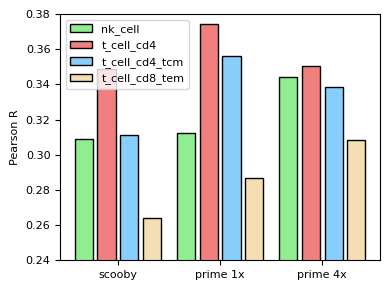

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


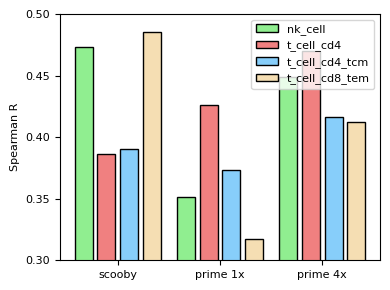

In [4]:
#Pearson R

model_index = np.arange(rp_mat.shape[0], dtype='int32')

f = plt.figure(figsize=(4, 3))

plt.bar(model_index * 4.5 + 0, rp_mat[:, 0], color='lightgreen', edgecolor='black', linewidth=1, label=tissues[0])
plt.bar(model_index * 4.5 + 1, rp_mat[:, 1], color='lightcoral', edgecolor='black', linewidth=1, label=tissues[1])
plt.bar(model_index * 4.5 + 2, rp_mat[:, 2], color='lightskyblue', edgecolor='black', linewidth=1, label=tissues[2])
plt.bar(model_index * 4.5 + 3, rp_mat[:, 3], color='wheat', edgecolor='black', linewidth=1, label=tissues[3])

plt.ylim(0.24, 0.38)

plt.xticks(model_index * 4.5 + 1.5, model_names, rotation=0, fontsize=8)
plt.yticks(fontsize=8)

plt.ylabel('Pearson R', fontsize=8)

plt.legend(fontsize=8)

plt.tight_layout()

plt.savefig('scooby_cmp_pearson.eps')

plt.show()

#Spearman R

model_index = np.arange(rs_mat.shape[0], dtype='int32')

f = plt.figure(figsize=(4, 3))

plt.bar(model_index * 4.5 + 0, rs_mat[:, 0], color='lightgreen', edgecolor='black', linewidth=1, label=tissues[0])
plt.bar(model_index * 4.5 + 1, rs_mat[:, 1], color='lightcoral', edgecolor='black', linewidth=1, label=tissues[1])
plt.bar(model_index * 4.5 + 2, rs_mat[:, 2], color='lightskyblue', edgecolor='black', linewidth=1, label=tissues[2])
plt.bar(model_index * 4.5 + 3, rs_mat[:, 3], color='wheat', edgecolor='black', linewidth=1, label=tissues[3])

plt.ylim(0.30, 0.50)

plt.xticks(model_index * 4.5 + 1.5, model_names, rotation=0, fontsize=8)
plt.yticks([0.30, 0.35, 0.40, 0.45, 0.50], fontsize=8)

plt.ylabel('Spearman R', fontsize=8)

plt.legend(fontsize=8)

plt.tight_layout()

plt.savefig('scooby_cmp_spearman.eps')

plt.show()


In [5]:
#(Re-)Calculate correlation metrics for all models; cutoff = 0.05 (from scooby paper)

model_names = [
    'scooby',
    'prime 1x',
    'prime 4x',
]

rp_mat = np.zeros((3, 4))
rs_mat = np.zeros((3, 4))
n_mat = np.zeros(4)

tissues = ['nk_cell', 't_cell_cd4', 't_cell_cd4_tcm', 't_cell_cd8_tem']
tissues_kw = ['NK cell', 'CD4+ T cell', 'CD4+ TCM cell', 'CD8+ TEM cell']

score_cols = ['nk_cell', 't_cell_cd4', 't_cell_cd4_tcm', 't_cell_cd8_tem']

cutoff = 0.05

#Loop over tissues
for tissue_i, [tissue, tissue_kw, score_col] in enumerate(zip(tissues, tissues_kw, score_cols)) :
    
    #Load borzoi prime scores
    df_borz_1 = pd.read_csv('../borzoi_prime_pbmc_onek1k_' + tissue + '_pseudo_ext_pos_1_fold.tsv', sep='\t')
    df_borz_1['unique_id'] = df_borz_1['snp'] + '_' + df_borz_1['finemap_gene_id']
    df_borz_1 = df_borz_1[['unique_id', 'beta', 'score_' + score_col]].rename(columns={'score_' + score_col : 'score_borzoi_1'}).copy()
    
    df_borz_4 = pd.read_csv('../borzoi_prime_pbmc_onek1k_' + tissue + '_pseudo_ext_pos.tsv', sep='\t')
    df_borz_4['unique_id'] = df_borz_4['snp'] + '_' + df_borz_4['finemap_gene_id']
    df_borz_4 = df_borz_4[['unique_id', 'score_' + score_col]].rename(columns={'score_' + score_col : 'score_borzoi_4'}).copy()

    #Join all dataframes
    df_overlap = scooby_df_unique.query("tissue_label == '" + tissue_kw + "'")[['unique_id', 'pred_effect']].rename(columns={'pred_effect' : 'score_scooby'}).copy().reset_index(drop=True)
    df_overlap = df_overlap.join(df_borz_1.set_index('unique_id'), on='unique_id', how='inner').copy()
    df_overlap = df_overlap.join(df_borz_4.set_index('unique_id'), on='unique_id', how='inner').copy()

    #Filter
    df_overlap_scooby = df_overlap.query("score_scooby > " + str(cutoff) + " or score_scooby < -" + str(cutoff)).copy().reset_index(drop=True)
    
    n_kept = len(df_overlap_scooby)
    
    #Get size-matched dataframes for other models
    df_overlap_borzoi_1 = df_overlap.sort_values(by='score_borzoi_1', ascending=False, key=lambda x: x.abs())[:n_kept].copy().reset_index(drop=True)
    df_overlap_borzoi_4 = df_overlap.sort_values(by='score_borzoi_4', ascending=False, key=lambda x: x.abs())[:n_kept].copy().reset_index(drop=True)

    #Calculate metrics
    
    n_mat[tissue_i] = n_kept
    
    rp_mat[0, tissue_i] = pearsonr(df_overlap_scooby['beta'], df_overlap_scooby['score_scooby'])[0]
    rp_mat[1, tissue_i] = pearsonr(df_overlap_borzoi_1['beta'], df_overlap_borzoi_1['score_borzoi_1'])[0]
    rp_mat[2, tissue_i] = pearsonr(df_overlap_borzoi_4['beta'], df_overlap_borzoi_4['score_borzoi_4'])[0]

    rs_mat[0, tissue_i] = spearmanr(df_overlap_scooby['beta'], df_overlap_scooby['score_scooby'])[0]
    rs_mat[1, tissue_i] = spearmanr(df_overlap_borzoi_1['beta'], df_overlap_borzoi_1['score_borzoi_1'])[0]
    rs_mat[2, tissue_i] = spearmanr(df_overlap_borzoi_4['beta'], df_overlap_borzoi_4['score_borzoi_4'])[0]

print("rp_mat.shape = " + str(rp_mat.shape))
print("rs_mat.shape = " + str(rs_mat.shape))
print("n_mat.shape = " + str(n_mat.shape))


rp_mat.shape = (3, 4)
rs_mat.shape = (3, 4)
n_mat.shape = (4,)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


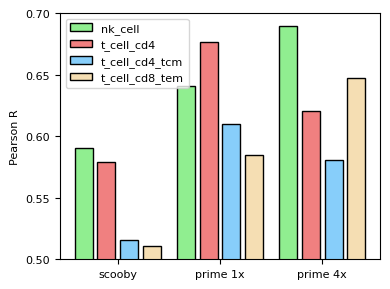

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


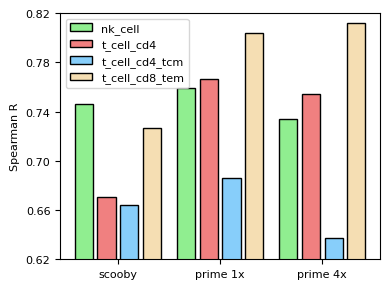

In [6]:
#Pearson R

model_index = np.arange(rp_mat.shape[0], dtype='int32')

f = plt.figure(figsize=(4, 3))

plt.bar(model_index * 4.5 + 0, rp_mat[:, 0], color='lightgreen', edgecolor='black', linewidth=1, label=tissues[0])
plt.bar(model_index * 4.5 + 1, rp_mat[:, 1], color='lightcoral', edgecolor='black', linewidth=1, label=tissues[1])
plt.bar(model_index * 4.5 + 2, rp_mat[:, 2], color='lightskyblue', edgecolor='black', linewidth=1, label=tissues[2])
plt.bar(model_index * 4.5 + 3, rp_mat[:, 3], color='wheat', edgecolor='black', linewidth=1, label=tissues[3])

plt.ylim(0.50, 0.70)

plt.xticks(model_index * 4.5 + 1.5, model_names, rotation=0, fontsize=8)
plt.yticks([0.50, 0.55, 0.60, 0.65, 0.70], fontsize=8)

plt.ylabel('Pearson R', fontsize=8)

plt.legend(fontsize=8)

plt.tight_layout()

plt.savefig('scooby_cmp_pearson_cutoff.eps')

plt.show()

#Spearman R

model_index = np.arange(rs_mat.shape[0], dtype='int32')

f = plt.figure(figsize=(4, 3))

plt.bar(model_index * 4.5 + 0, rs_mat[:, 0], color='lightgreen', edgecolor='black', linewidth=1, label=tissues[0])
plt.bar(model_index * 4.5 + 1, rs_mat[:, 1], color='lightcoral', edgecolor='black', linewidth=1, label=tissues[1])
plt.bar(model_index * 4.5 + 2, rs_mat[:, 2], color='lightskyblue', edgecolor='black', linewidth=1, label=tissues[2])
plt.bar(model_index * 4.5 + 3, rs_mat[:, 3], color='wheat', edgecolor='black', linewidth=1, label=tissues[3])

plt.ylim(0.62, 0.82)

plt.xticks(model_index * 4.5 + 1.5, model_names, rotation=0, fontsize=8)
plt.yticks([0.62, 0.66, 0.70, 0.74, 0.78, 0.82], fontsize=8)

plt.ylabel('Spearman R', fontsize=8)

plt.legend(fontsize=8)

plt.tight_layout()

plt.savefig('scooby_cmp_spearman_cutoff.eps')

plt.show()
